<a href="https://colab.research.google.com/github/dmaresza/tensorflow_course/blob/main/05_TensorFlow_Transfer_Learning_Part_2_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Fine-tuning

## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [1]:
# Useful imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import helper functions to use in this notebook
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves, unzip_data

--2024-07-11 23:35:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-11 23:35:09 (71.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")
!rm 10_food_classes_10_percent.zip

--2024-07-11 23:35:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.2MB/s    in 8.3s    

2024-07-11 23:35:18 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
# Create train and test data loaders
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
images, labels = train_data_10_percent.as_numpy_iterator().next()
print(images[0])

[[[211.58673  173.58673  102.58674 ]
  [209.5051   172.5051   101.5051  ]
  [210.7347   173.7347   104.16327 ]
  ...
  [195.78055  184.49994  156.78569 ]
  [210.22466  199.03079  173.34201 ]
  [235.8064   225.9595   202.03093 ]]

 [[211.78572  174.78572  103.78571 ]
  [211.85204  174.85204  104.85204 ]
  [213.08673  176.08673  106.515305]
  ...
  [215.30095  201.37238  166.15814 ]
  [204.10204  189.32146  158.53572 ]
  [202.69902  188.84189  160.05617 ]]

 [[212.7857   176.42857  106.21429 ]
  [210.95407  174.59694  104.38265 ]
  [207.85715  171.62245  102.38776 ]
  ...
  [225.14285  206.18872  162.6429  ]
  [212.52022  194.50494  153.79065 ]
  [207.18927  189.96997  150.75565 ]]

 ...

 [[237.19386  203.40813   51.70412 ]
  [241.07658  208.02046   54.704185]
  [240.49493  207.4031    52.020485]
  ...
  [220.57639  197.36212  101.57669 ]
  [200.68344  180.25491  107.367546]
  [193.59633  171.44846  120.15812 ]]

 [[243.80618  208.78067   64.97458 ]
  [246.5204   211.5204    65.80614 ]


In [9]:
# Create model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# Freeze base model layers for feature extraction
base_model.trainable = False

# Create input layer for the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass the inputs to the base_model
x = base_model(inputs)

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

24274472/24274472 [==============================] - 2s 0us/step


In [10]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_frequency="epoch", # save every epoch
                                                         verbose=1)

In [11]:
# Fit the model saving checkpoints every epoch
initial_epochs = 10
history_0 = model_0.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8950 - accuracy: 0.4307
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 289ms/step - loss: 1.8950 - accuracy: 0.4307 - val_loss: 1.3126 - val_accuracy: 0.7533
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.1364 - accuracy: 0.7663
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 141ms/step - loss: 1.1360 - accuracy: 0.7627 - val_loss: 0.8812 - val_accuracy: 0.8240
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.8357 - accuracy: 0.8152
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 148ms/step - loss: 0.8346 - accuracy: 0.8147 - val_loss: 0.6946 - val_accuracy: 0.8569
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 

In [12]:
# Evaluate model on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.4443 - accuracy: 0.8712


[0.4443351626396179, 0.8712000250816345]

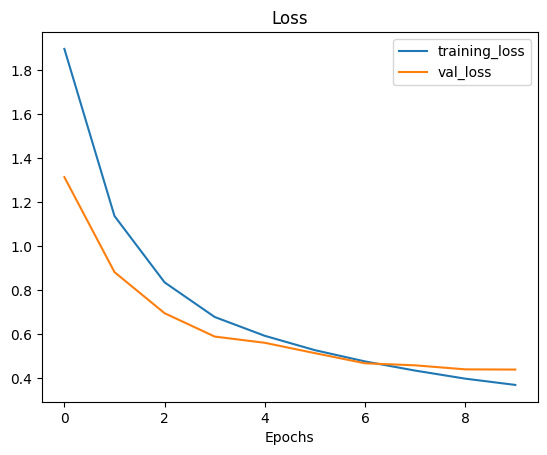

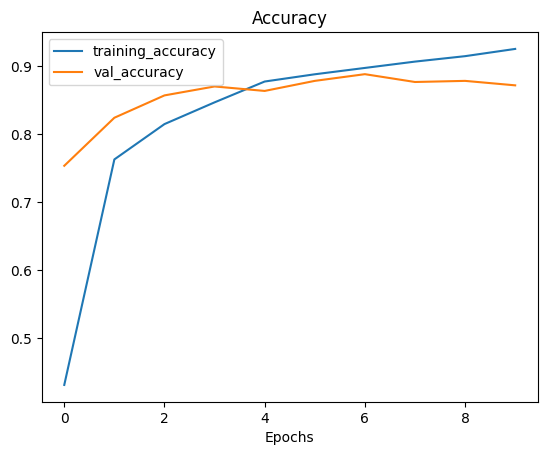

In [13]:
# View loss and accuracy curves
plot_loss_curves(history_0)

## 2. Fine-tune the last 20 layers of the base model you trained in #1 for another 10 epochs. How did it go?

In [14]:
# Load in saved model weights for fine-tuning
model_0.load_weights(checkpoint_path)

In [15]:
# Make the base model trainable for fine-tuning
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile model 0 to update changes
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lower training rate by 10x for fine-tuning
                metrics=["accuracy"])

In [16]:
# Check to make sure model now has trainable layers
for i, layer in enumerate(model_0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [17]:
# Fine-tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2, but with more trainable layers)
history_fine_20_layers = model_0.fit(train_data_10_percent,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_0.epoch[-1], # start training from previous last epoch
                                     )

Epoch 10/20
24/24 [==============================] - 18s 242ms/step - loss: 0.4532 - accuracy: 0.8933 - val_loss: 0.3545 - val_accuracy: 0.8914
Epoch 11/20
24/24 [==============================] - 3s 125ms/step - loss: 0.1727 - accuracy: 0.9587 - val_loss: 0.3190 - val_accuracy: 0.8865
Epoch 12/20
24/24 [==============================] - 3s 126ms/step - loss: 0.1151 - accuracy: 0.9853 - val_loss: 0.3181 - val_accuracy: 0.9046
Epoch 13/20
24/24 [==============================] - 5s 177ms/step - loss: 0.0624 - accuracy: 0.9920 - val_loss: 0.2942 - val_accuracy: 0.8947
Epoch 14/20
24/24 [==============================] - 5s 177ms/step - loss: 0.0512 - accuracy: 0.9933 - val_loss: 0.2749 - val_accuracy: 0.9062
Epoch 15/20
24/24 [==============================] - 4s 125ms/step - loss: 0.0448 - accuracy: 0.9920 - val_loss: 0.3161 - val_accuracy: 0.9013
Epoch 16/20
24/24 [==============================] - 3s 125ms/step - loss: 0.0302 - accuracy: 0.9973 - val_loss: 0.2566 - val_accuracy: 0.914

In [18]:
# Evaluate model on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.3639 - accuracy: 0.8944


[0.3638516366481781, 0.8944000005722046]

In [19]:
# Creating a function to compare training histories from before & after fine-tuning
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get orginal history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

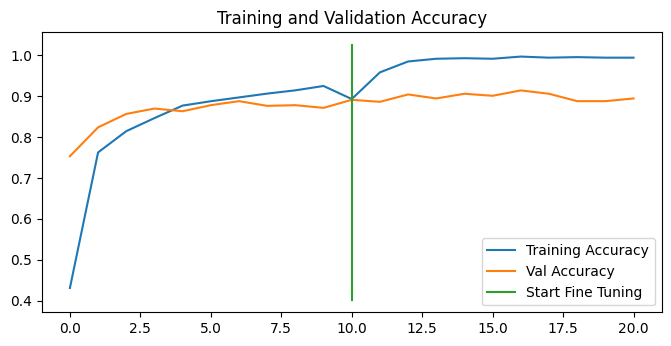

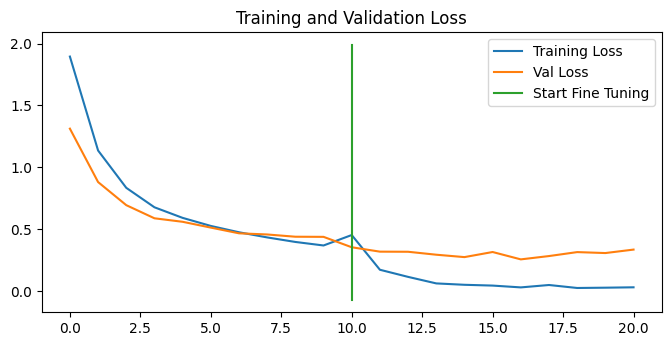

In [20]:
compare_histories(history_0,
                  history_fine_20_layers,
                  initial_epochs=10)

Fine-tuning the last 20 layers of the model seemed to improve the accuracy on the test data by ~2%, from ~87.1% to ~89.4%.

## 3. Fine-tune the last 30 layers of the base model you trained in #1 for another 10 epochs. How did it go?

In [21]:
# Recreate model to avoid shape mismatches when reloading weights
model_1 = tf.keras.Model(inputs, outputs)

# Load in saved model weights for fine-tuning
model_1.load_weights(checkpoint_path)

In [22]:
# Make the base model trainable for fine-tuning
base_model.trainable = True

# Freeze all layers except for the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile model 0 to update changes
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lower training rate by 10x for fine-tuning
                metrics=["accuracy"])

In [23]:
# Fine-tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2, but with more trainable layers)
history_fine_30_layers = model_1.fit(train_data_10_percent,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data_10_percent),
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_0.epoch[-1], # start training from previous last epoch
                                     )

Epoch 10/20
24/24 [==============================] - 16s 196ms/step - loss: 0.5669 - accuracy: 0.8400 - val_loss: 0.4607 - val_accuracy: 0.8553
Epoch 11/20
24/24 [==============================] - 6s 204ms/step - loss: 0.1860 - accuracy: 0.9493 - val_loss: 0.3698 - val_accuracy: 0.8849
Epoch 12/20
24/24 [==============================] - 5s 178ms/step - loss: 0.0563 - accuracy: 0.9907 - val_loss: 0.3317 - val_accuracy: 0.8882
Epoch 13/20
24/24 [==============================] - 4s 173ms/step - loss: 0.0393 - accuracy: 0.9920 - val_loss: 0.3316 - val_accuracy: 0.8947
Epoch 14/20
24/24 [==============================] - 3s 128ms/step - loss: 0.0328 - accuracy: 0.9947 - val_loss: 0.3229 - val_accuracy: 0.8964
Epoch 15/20
24/24 [==============================] - 5s 175ms/step - loss: 0.0243 - accuracy: 0.9947 - val_loss: 0.2856 - val_accuracy: 0.9095
Epoch 16/20
24/24 [==============================] - 8s 265ms/step - loss: 0.0318 - accuracy: 0.9933 - val_loss: 0.3077 - val_accuracy: 0.896

In [24]:
# Evaluate model on full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 5s 60ms/step - loss: 0.3444 - accuracy: 0.8992


[0.34437841176986694, 0.8992000222206116]

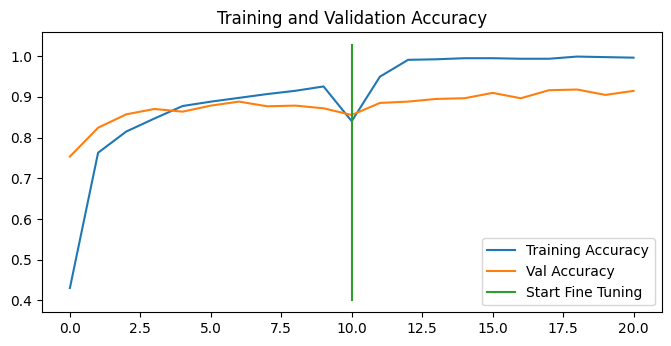

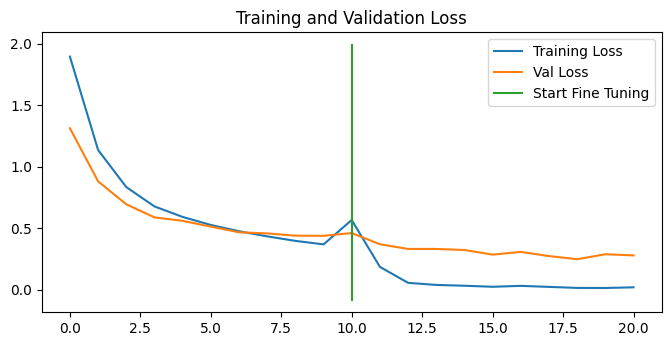

In [25]:
compare_histories(history_0,
                  history_fine_30_layers,
                  initial_epochs=10)

Fine-tuning the last 30 layers didn't have as much of an improvement compared to fine-tuning only the last 20 layers. The evaluation accuracy on the test data improved only by ~0.5%, from ~89.4% in problem #2 to ~89.9%.

## 4. Write a function to take an image from any dataset (train or test file) and any class (e.g. "steak, "pizza", etc.), visualize it, and make a prediction on it using a trained model.

In [47]:
def predict_on_image(filename, class_names, model):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Read in target image
  img = tf.io.read_file(filename)

  # Turn image into tensor
  img = tf.image.decode_image(img)

  # Resize image
  img = tf.image.resize(img, size=[224, 224])

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Rescale image before plotting
  img = img/255.

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 26ms/step


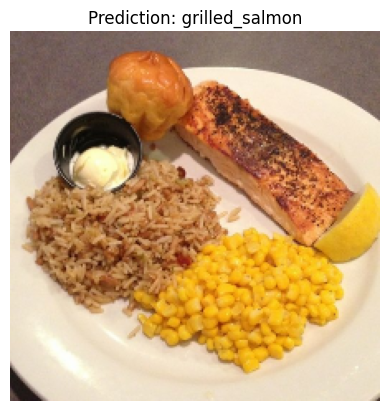

In [49]:
import os
import random

class_names = train_data_10_percent.class_names
random_class = random.choice(class_names)
# target_dir = train_dir + "/" + random_class # uncomment this line and comment out the line below to predict on a training image
target_dir = test_dir + "/" + random_class # comment out this line and uncomment the line above to predict on a training image
random_test_image = target_dir + "/" + random.choice(os.listdir(target_dir))
predict_on_image(random_test_image, class_names, model_1)